In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score


In [3]:
path_to_data = "../../../dataset_offline/ft2model/"

targets_df = pd.read_parquet(path_to_data + "target_pandas.parquet")
dataset = pd.read_parquet(path_to_data + "filtered_features.parquet")

dataset = dataset.drop_duplicates(subset='ID_CLIENTE_BIC', keep='first')

targets_df = targets_df.sort_values(by='ID_CLIENTE_BIC', ascending=True)
dataset = dataset.sort_values(by='ID_CLIENTE_BIC', ascending=True)


# Preprocessing

In [12]:
## fare label encoding o hot encoding
# Codifica le variabili categoriche (sostituisci 'colonne_categoriche' con il nome delle tue colonne)
X_encoded = pd.get_dummies(dataset, columns=[])

# Dataset preparation

In [13]:
# Definisci le feature (X) e il target (y)
X = X_encoded
y = targets_df['TARGET']

# Esegui lo split dei dati
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Tuning Parametri

In [32]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.12, 0.13, 0.15],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.5,1],
    
}

model = XGBClassifier()
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params

{'colsample_bytree': 0.5,
 'learning_rate': 0.13,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 1}

# Model Training

In [10]:
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Tuning della treshold

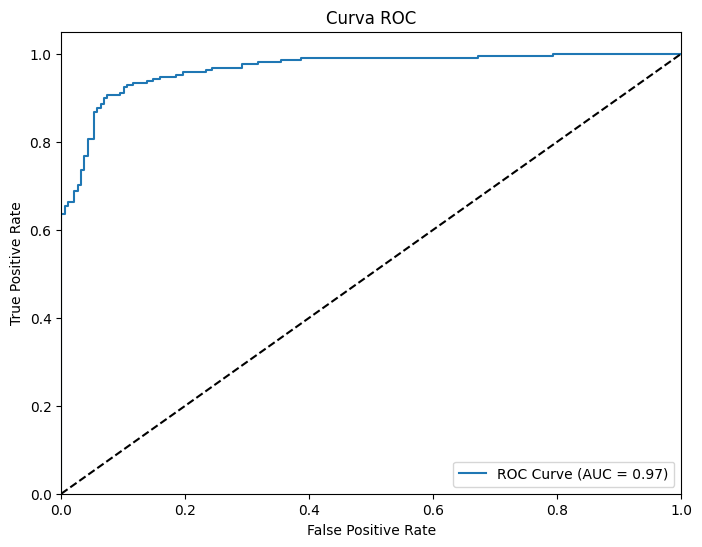

Miglior Threshold: 0.54
F1 Score Ottimizzato: 0.92


In [19]:
# Calcola le probabilità di classe previste dal modello
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilità della classe positiva

# Calcola la curva ROC e l'area sotto la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plotta la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Calcola il valore F1-score ottimizzato
f1_scores = []
for threshold in thresholds:
    y_pred_threshold = [1 if prob >= threshold else 0 for prob in y_pred_prob]
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f'Miglior Threshold: {best_threshold:.2f}')
print(f'F1 Score Ottimizzato: {best_f1_score:.2f}')

# Metric Calculation

In [20]:
# Previsioni sul set di test
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilità della classe positiva
y_pred_threshold = [1 if prob >= best_threshold else 0 for prob in y_pred_prob]


# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
roc_auc_score_value = roc_auc_score(y_test, y_pred_threshold)

# Stampa le metriche
print(f'Accuratezza: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Roc auc score: {roc_auc_score_value}')

# Aggiungere il confronto con un dummymodel.
# Stampare un pandas con colonne metriche e e righe modello vs dummymodel

Accuratezza: 0.915
Precision: 0.9317073170731708
Recall: 0.9052132701421801
F1 Score: 0.9182692307692308
Roc auc score: 0.915569598034053


# Confusion Matrix

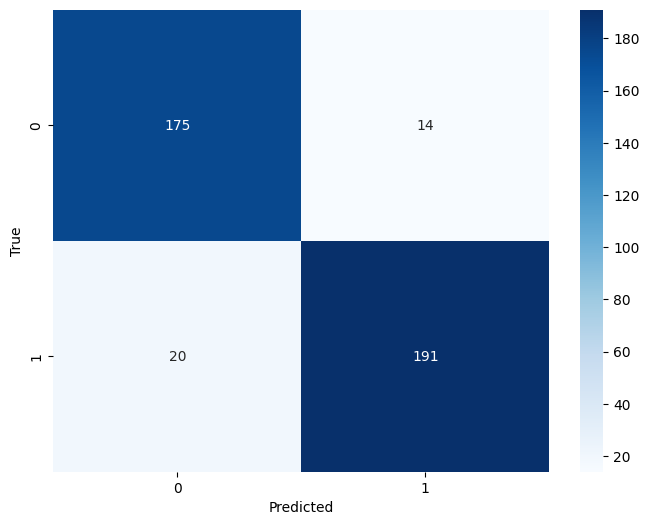

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Cross Validation

In [59]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
print(f'Cross-Validation Precision Scores: {cv_scores}')
print(f'Average Precision: {np.mean(cv_scores)}')


Cross-Validation Precision Scores: [0.92356688 0.91139241 0.94193548 0.94039735 0.9245283 ]
Average Precision: 0.9283640841590641


# Calcolo Della Features Importance

In [58]:
# Calcola l'importanza delle feature
feature_importance = model.feature_importances_

# Crea un DataFrame per visualizzare le importanze delle feature
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Ordina le feature per importanza in ordine decrescente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizza le importanze delle feature
feature_importance_df

,Feature,Importance
1,somma_entrate_entrate_regolari__number_peaks__n_3,0.205148
2,somma_entrate_scambio_soldi_tra_privati__numbe...,0.090071
5,somma_entrate_scambio_soldi_tra_privati__numbe...,0.068274
16,somma_entrate_entrate_occasionali__number_peak...,0.038109
28,somma_entrate_entrate_regolari__last_location_...,0.028937
...,...,...
23,somma_uscite_scambio_soldi_tra_privati__number...,0.000000
75,somma_entrate_investimenti_patrimonio__c3__lag_1,0.000000
47,somma_uscite_scambio_soldi_tra_privati__c3__lag_3,0.000000
77,somma_uscite_altre_spese__number_peaks__n_50,0.000000
